In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [4]:
def mouth_extractor(file_path: str, scale_factor=1.3, min_neighbors=5, mouth_size=(140, 70)) -> None:
    """
    Extract the mouth from the video and save as an npy file
    :param file_path: Path to the video file
    :param scale_factor: Parameter specifying how much the image size is reduced at each image scale
    :param min_neighbors: Parameter specifying how many neighbors each candidate rectangle should have to retain it
    :param mouth_size: Size of the extracted mouth region
    :return: None
    """
    base_path = file_path.split('.')[0]
    # if not os.path.exists(base_path + '.npy'):
    if file_path.endswith('.mpg'):
        cap = cv2.VideoCapture(file_path)
        if not cap.isOpened():
            raise Exception("Error: Could not open video.")

        frames = []
        for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
            ret, frame = cap.read()
            if not ret:
                raise Exception("Error: Could not read frame.")
            # 参数分别为低阈值和高阈值
            faces = face_cascade.detectMultiScale(frame, scale_factor, min_neighbors)
            for (x, y, w, h) in faces:
                mouth_roi = frame[y + int(h / 2):y + h, x:x + w, :]

                mouth_roi = cv2.resize(mouth_roi, mouth_size)
                frames.append(mouth_roi)

        cap.release()

        # Normalize frames
        frames_tensor = np.array(frames)
        mean = np.mean(frames_tensor)
        std = np.std(frames)
        frames_tensor = (frames - mean) / std
        # frames_tensor = np.expand_dims(frames_tensor, axis=-1)
        # Save as npy file

        np.save(base_path + '.npy', frames_tensor)
        return frames_tensor
    else:
        raise Exception("Error: File format not supported.")

(75, 70, 140, 3)


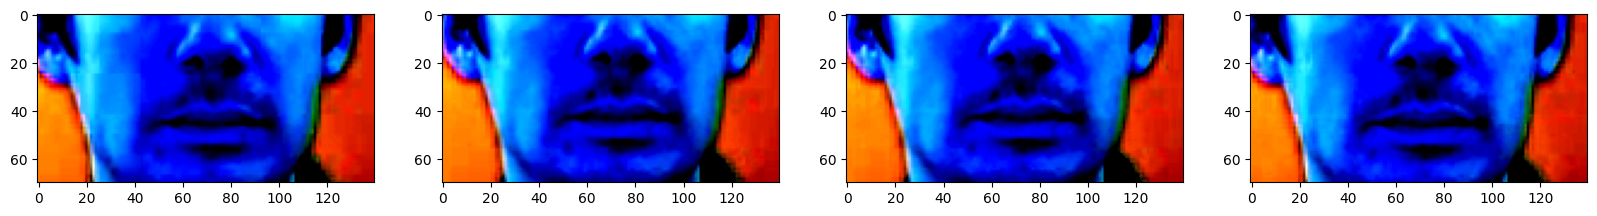

In [5]:
frames_tensor = mouth_extractor('/Users/zhenyili/research project/src/lipNet/data/s1/bbbmzn.mpg')
print(frames_tensor.shape)
# show the first 10 frames the np shape is (75, 1, 70, 140)
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
frames_tensor = np.clip(frames_tensor, 0, 1)
# print(frames_tensor[0])
for i in range(4):
    ax[i].imshow(frames_tensor[i])
    # ax[i].axis('off')  # no axes for this plot



(75, 70, 140, 3)
[[[0.         0.         0.55649094]
  [0.         0.         0.14956384]
  [0.         0.         0.        ]
  ...
  [0.80839819 0.14956384 0.        ]
  [0.80839819 0.14956384 0.        ]
  [0.9052856  0.20769628 0.        ]]

 [[0.         0.         0.55649094]
  [0.         0.         0.14956384]
  [0.         0.         0.        ]
  ...
  [0.80839819 0.14956384 0.        ]
  [0.80839819 0.14956384 0.        ]
  [0.9052856  0.20769628 0.        ]]

 [[0.         0.         0.76964323]
  [0.         0.         0.26582872]
  [0.         0.         0.01392147]
  ...
  [0.84715316 0.14956384 0.        ]
  [0.84715316 0.14956384 0.        ]
  [0.94404056 0.16894132 0.        ]]

 ...

 [[1.         0.4983585  0.        ]
  [1.         0.44022605 0.        ]
  [1.         0.44022605 0.        ]
  ...
  [0.69213331 0.         0.        ]
  [0.69213331 0.         0.        ]
  [0.69213331 0.         0.        ]]

 [[1.         0.4983585  0.        ]
  [1.         0.4402

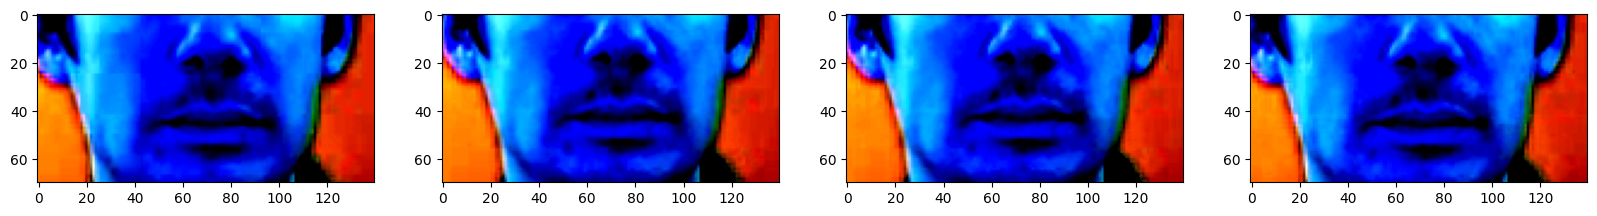

In [8]:
frames_tensor = mouth_extractor('/Users/zhenyili/research project/src/lipNet/data/s1/bbbmzn.mpg')
print(frames_tensor.shape)
# show the first 10 frames the np shape is (75, 1, 70, 140)
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
frames_tensor = np.clip(frames_tensor, 0, 1)
# print(frames_tensor[0])
for i in range(4):
    ax[i].imshow(frames_tensor[i])
    # ax[i].axis('off')  # no axes for this plot



TypeError: Invalid shape (70, 140, 3, 1) for image data

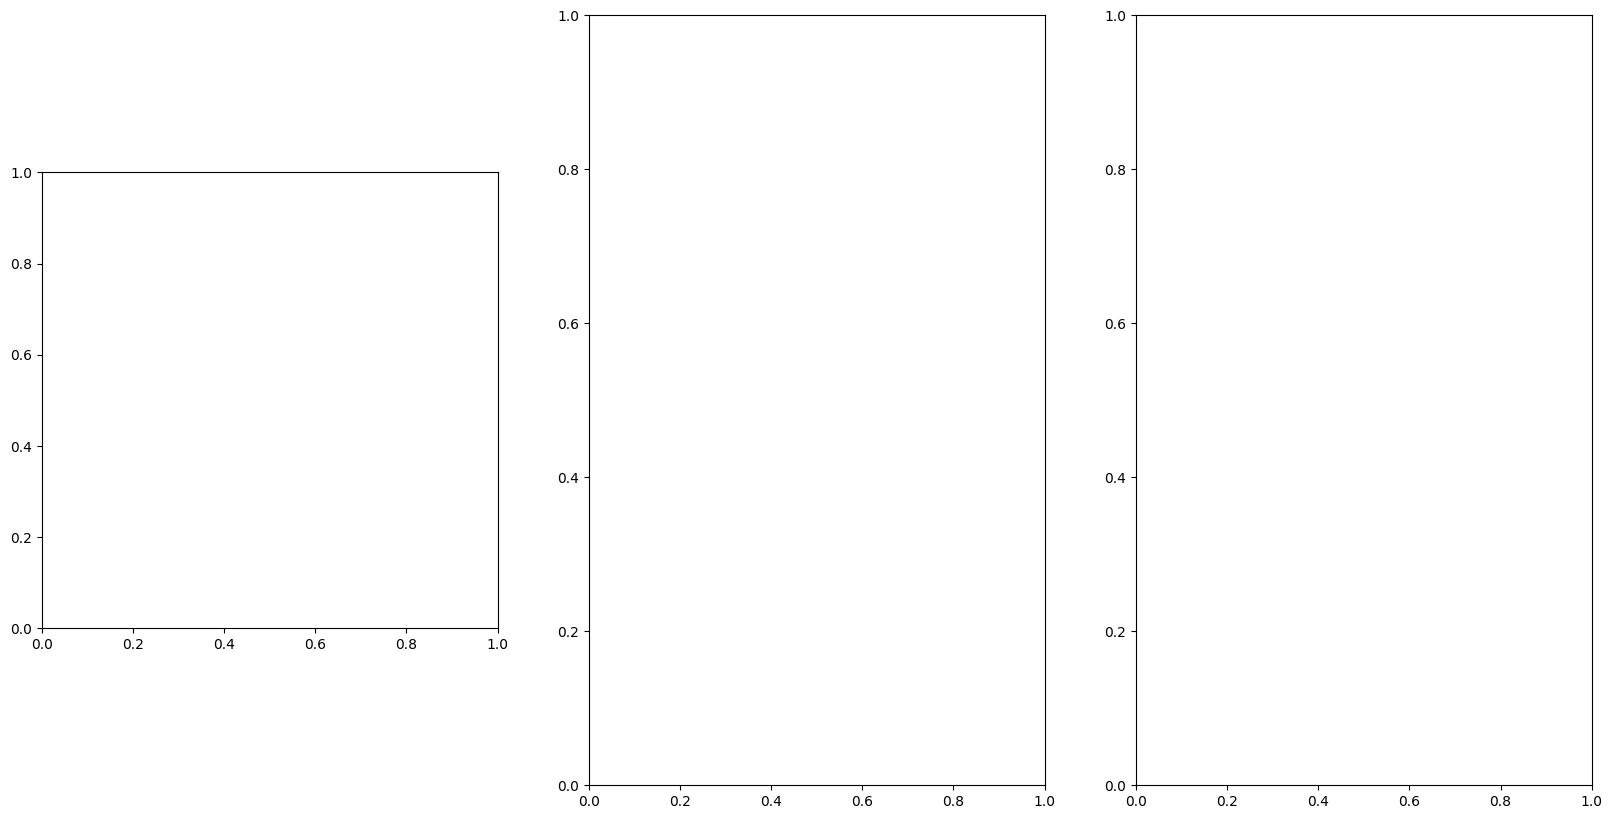

In [9]:
frames_tensor = mouth_extractor('../data/s1/bbbmzn.mpg')
# show the first 10 frames
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
for i in range(3):
    ax[i].imshow(frames_tensor[i], )
    ax[i].axis('off')  # no axes for this plot
plt.show()

In [64]:
np.load('/Users/zhenyili/research project/src/lipNet/data/s1/bbbmzn.npy').shape

(75, 70, 140, 1)

In [146]:
np.load('/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/s1/bbbmzn.npy').shape

(75, 1, 70, 140)

In [6]:
import logging
import os
import glob
from typing import List, Tuple
import torch


def load_data(dir) -> List[Tuple[torch.Tensor, torch.Tensor]]:
    data = []
    # 递归搜索该目录下的文件含有align的文件
    alignments = glob.glob(dir + '/**/*.align', recursive=True)
    alignments_dict = {}
    for align in alignments:
        alignments_dict[align.split('/')[-1].split('.')[0]] = load_alignments(align)
    for root, dir, files in os.walk(dir):
        for file in files:
            if file.endswith('.npy'):
                video_frames = np.load(os.path.join(root, file))
                video_frames = torch.from_numpy(video_frames).float()
                filename = file.split('.')[0]
                if filename in alignments_dict:
                    alignments = alignments_dict[filename]
                else:
                    logging.warning(f'No alignment found for {filename}')
                    alignments = ''
                data.append((video_frames, alignments))
    return data


def load_alignments(path: str) -> torch.Tensor:
    with open(path, 'r') as f:
        lines = f.readlines()
        tokens = ''
        for line in lines:
            line = line.split()
            if line[2] != 'sil':
                tokens = tokens + ' ' + line[2]
        tokens_np = np.array([ord(c) for c in tokens])
        tokens_tensor = torch.from_numpy(tokens_np).float()
        return tokens_tensor

In [33]:
data = load_data('/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/')
print(data[0][0].shape)

IndexError: list index out of range

In [101]:
print(data[0][1].shape)

torch.Size([22])


In [7]:
def pretain(dir: str) -> List:
    """
    find all the video and extra the mouth region 
    :param dir: 
    :return: 
    """
    video_list = glob.glob(dir + '/**/*.mpg', recursive=True)
    return video_list


In [10]:
video_list = pretain('/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data')


In [8]:
video_list = pretain('/Users/zhenyili/research project/src/lipNet/data')

In [9]:
print(video_list[:10])

['/Users/zhenyili/research project/src/lipNet/data/s1/prwq3s.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/pbib8p.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/lrae3s.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/pgid6p.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/pbao8n.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/prbx3s.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/lbbk6p.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/bgwu6n.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/sbig6p.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/pgby5s.mpg']


In [10]:

for i in range(10):
    mouth_extractor(video_list[i])


In [11]:
from config import DIR
from dataset import LRNetDataset
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Subset
from typing import Any, Tuple


def load_train_test_data() -> list[Subset[Any]]:
    video_dataset = LRNetDataset(DIR)
    train_size = int(0.8 * len(video_dataset))
    test_size = len(video_dataset) - train_size
    return torch.utils.data.random_split(video_dataset, [train_size, test_size])


def collate_fn(batch: list[Tuple[torch.Tensor, torch.Tensor]]) -> Tuple[torch.Tensor, torch.Tensor]:
    inputs_tensors, targets_tensors = zip(*batch)
    padded_inputs = pad_sequence(inputs_tensors, batch_first=True, padding_value=0)
    padded_inputs = padded_inputs.permute(0, 4, 1, 2, 3)
    padded_targets = pad_sequence(targets_tensors, batch_first=True, padding_value=0)
    return padded_inputs, padded_targets,


In [14]:

from dataset_loader import LRNetDataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_dataset, val_dataset = load_train_test_data()
train_loader = LRNetDataLoader(train_dataset, batch_size=32, shuffle=True)

the total alignments files is 1000


In [15]:
sample_inputs, *args = next(iter(train_loader))


In [16]:
sample_inputs, _ = next(iter(train_loader))
print(sample_inputs.shape)
print(_.shape)

torch.Size([8, 3, 75, 70, 140])
torch.Size([8, 29])


In [17]:
input_shape = sample_inputs.shape

print(input_shape)
print(list(map(lambda x: x.shape, args)))

torch.Size([8, 3, 75, 70, 140])
[torch.Size([8, 29])]


In [104]:
input_channels = input_shape[1]
print(input_channels)

1


In [105]:
from model import LRModel
from torch import nn, optim

model = LRModel().to(device)
criterion = nn.CTCLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loss_curve, val_loss_curve, train_wer_curve, val_wer_curve = [], [], [], []

In [107]:


from tqdm import tqdm

for epoch in tqdm(range(10)):
    train_loss = 0
    val_loss = 0
    train_wer = 0
    val_wer = 0
    print(f'Epoch {epoch + 1}/{10}')
    for i, (inputs, targets) in enumerate(train_loader):
        # #[32, 75, 1, 70, 140]->[32,1,75,70,140]
        # inputs = torch.permute(inputs, (0, 2, 1, 3, 4))
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long)
        target_lengths = torch.full(size=(targets.size(0),), fill_value=targets.size(1), dtype=torch.long)
        loss = criterion(outputs, targets, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if i % 10 == 0:
            print(f'Epoch {epoch + 1}/{10}, Step {i}/{len(train_loader)}, Loss: {loss.item():.4f}')
    train_loss /= len(train_loader)
    train_loss_curve.append(train_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


  0%|          | 0/10 [00:58<?, ?it/s]


KeyboardInterrupt: 

['', '', '', '']
